# Consumer Price Comparison of Essential Items in Pakistan

**Data Source:** Pakistan Bureau of Statistics (PBS) – Weekly Sensitive Price Indicator (SPI)

**Objective:**  
This notebook compares the average prices of essential items across major Pakistani cities for two weeks: 24-04-2025 (previous week) and 07-08-2025 (current week).  
We will visualize the **price differences** using heatmaps to quickly identify which items and cities experienced price increases or decreases.


## 1. Importing Libraries
We will use the following Python libraries:
- `pandas` for data manipulation
- `matplotlib` and `seaborn` for visualization


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid", palette="pastel")

## 2. Helper Function
We create a function to make column names unique and another to clean the weekly Excel files.


In [2]:
# Function to make column names unique
def make_columns_unique(cols):
    seen = {}
    unique_cols = []
    for col in cols:
        if col not in seen:
            seen[col] = 0
            unique_cols.append(col)
        else:
            seen[col] += 1
            unique_cols.append(f"{col}.{seen[col]}")
    return unique_cols


In [3]:
# Function to Clean Each Excel File
def clean_price_file(file_path):
    sheets = pd.read_excel(file_path, sheet_name=None, skiprows=2, header=[0,1])
    all_data = []
    for sheet_name, df in sheets.items():
        df.columns = [
            f"{str(a).strip()}_{str(b).strip()}" if "nan" not in f"{str(a).lower()}_{str(b).lower()}" else str(a).strip()
            for a, b in df.columns
        ]
        desc_col = [col for col in df.columns if "DESCRIPTION" in col.upper()]
        avg_cols = [col for col in df.columns if "AVG" in col.upper()]
        df = df.dropna(subset=desc_col, how='all')
        df_filtered = df[desc_col + avg_cols]
        df_filtered.columns = [col.replace("_AVG", "").title() for col in df_filtered.columns]
        df_filtered.columns = make_columns_unique(df_filtered.columns)
        all_data.append(df_filtered)
    df_combined = pd.concat(all_data, axis=1)
    desc_col_final = df_combined.columns[0]
    df_combined = df_combined.loc[:, ~df_combined.columns.duplicated()]
    df_top = df_combined.head(21).set_index(desc_col_final)
    df_top = df_top.drop(df_top.index[0])
    df_numeric = df_top.apply(pd.to_numeric, errors='coerce')
    return df_numeric

## 3. Load Data
We load data for **previous week** and **current week**.


In [4]:
# File paths
file_prev_week = r"C:\Users\zotac\Downloads\SPI-Annex_24.04.2025.xlsx"
file_this_week = r"C:\Users\zotac\Downloads\Annex_07.08.2025.xlsx"

# Clean and prepare both weeks
df_prev = clean_price_file(file_prev_week)
df_this = clean_price_file(file_this_week)


## 4. Previous Week Heatmap
Visualize prices of essential items for the **previous week**, highlighting the **highest price per item** in red.


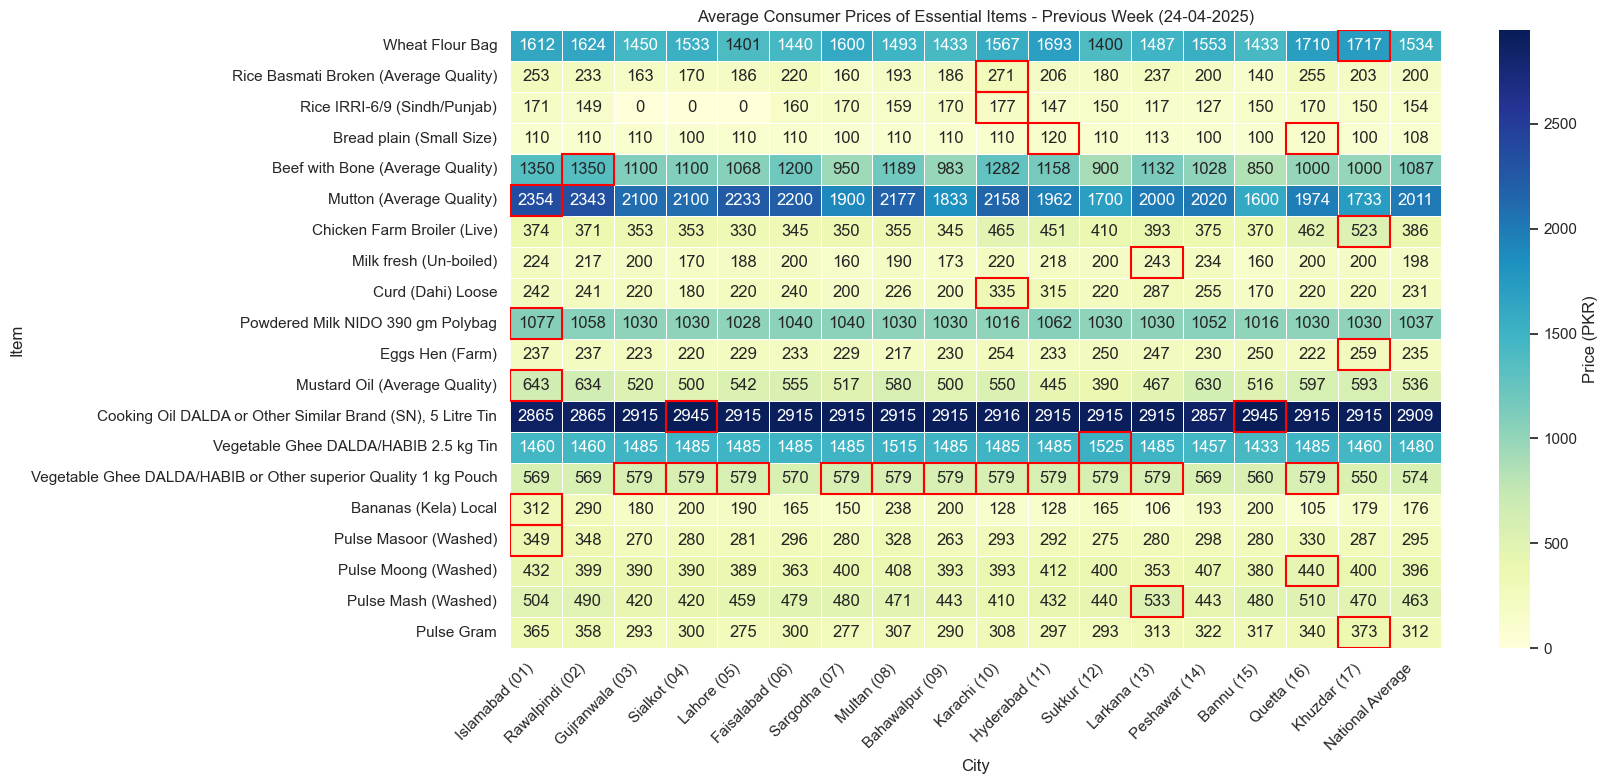

In [5]:
# Previous Week
plt.figure(figsize=(17, 8))
sns.heatmap(df_prev, annot=True, fmt=".0f", cmap="YlGnBu", linewidths=0.5, cbar_kws={'label': 'Price (PKR)'})

# Highlight the max price in each row with a red box
max_mask_prev = df_prev.eq(df_prev.max(axis=1), axis=0)
for y in range(df_prev.shape[0]):
    for x in range(df_prev.shape[1]):
        if max_mask_prev.iloc[y, x]:
            plt.gca().add_patch(plt.Rectangle((x, y), 1, 1, fill=False, edgecolor='red', lw=1.5))

plt.title("Average Consumer Prices of Essential Items - Previous Week (24-04-2025)")
plt.ylabel("Item")
plt.xlabel("City")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

## 5. Current Week Heatmap
Visualize prices for the **current week** and highlight the highest price per item.


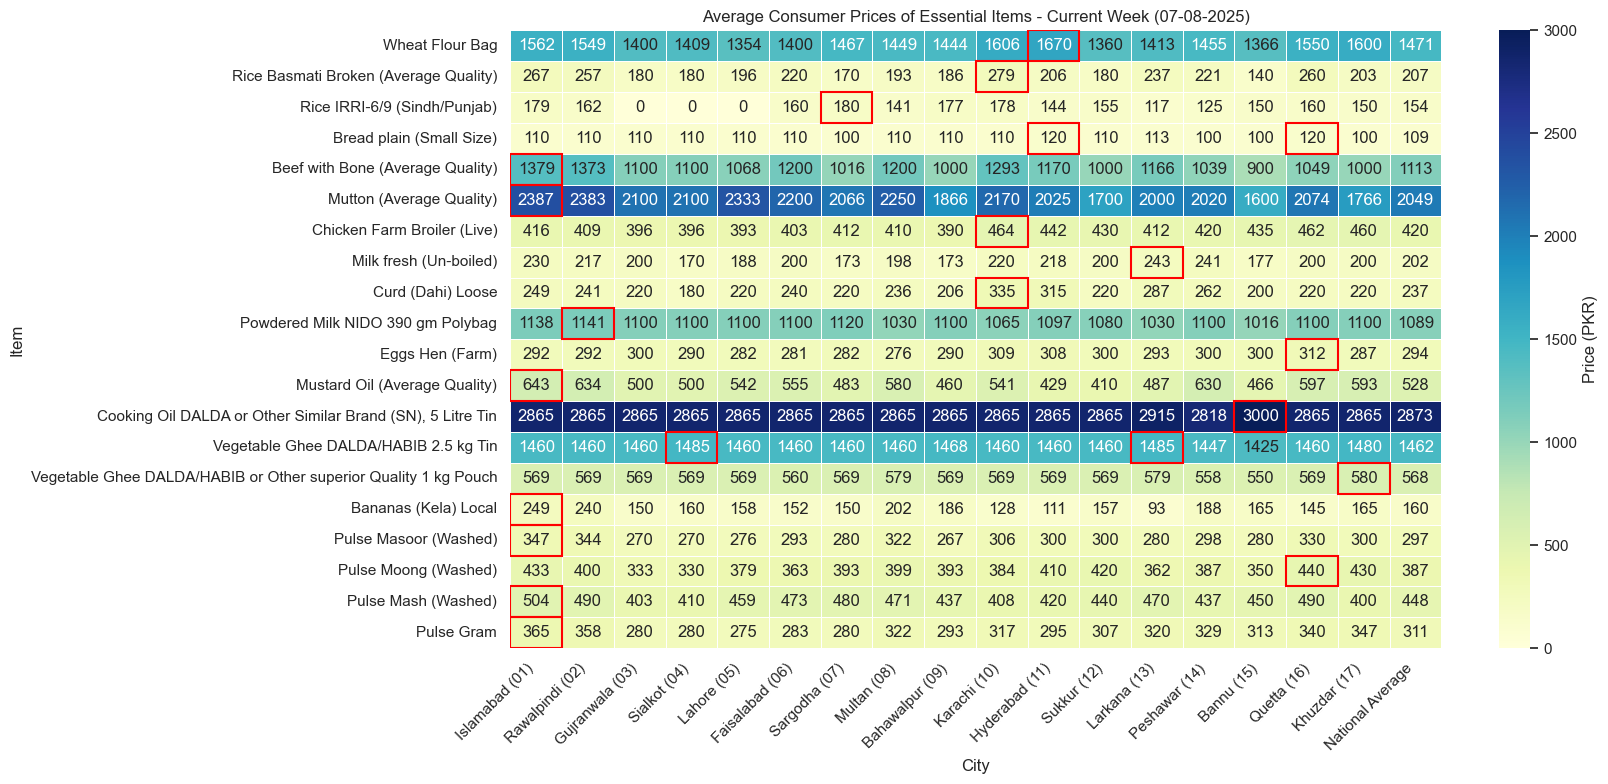

In [6]:
# Current Week
plt.figure(figsize=(17, 8))
sns.heatmap(df_this, annot=True, fmt=".0f", cmap="YlGnBu", linewidths=0.5, cbar_kws={'label': 'Price (PKR)'})

# Highlight the max price in each row with a red box
max_mask_this = df_this.eq(df_this.max(axis=1), axis=0)
for y in range(df_this.shape[0]):
    for x in range(df_this.shape[1]):
        if max_mask_this.iloc[y, x]:
            plt.gca().add_patch(plt.Rectangle((x, y), 1, 1, fill=False, edgecolor='red', lw=1.5))

plt.title("Average Consumer Prices of Essential Items - Current Week (07-08-2025)")
plt.ylabel("Item")
plt.xlabel("City")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

## 6. Price Comparison
We calculate the **difference in prices** between current and previous week to see which items increased or decreased in each city.


In [7]:
# Merge datasets and calculate differences
df_compare = df_this.join(df_prev, lsuffix='_ThisWeek', rsuffix='_PrevWeek')
for col in df_this.columns:
    prev_col = col + '_PrevWeek'
    this_col = col + '_ThisWeek'
    if prev_col in df_compare.columns:
        df_compare[col + '_Diff'] = df_compare[this_col] - df_compare[prev_col]

diff_cols = [col for col in df_compare.columns if col.endswith('_Diff')]
df_diff = df_compare[diff_cols]

## 7. Heatmap of price changes

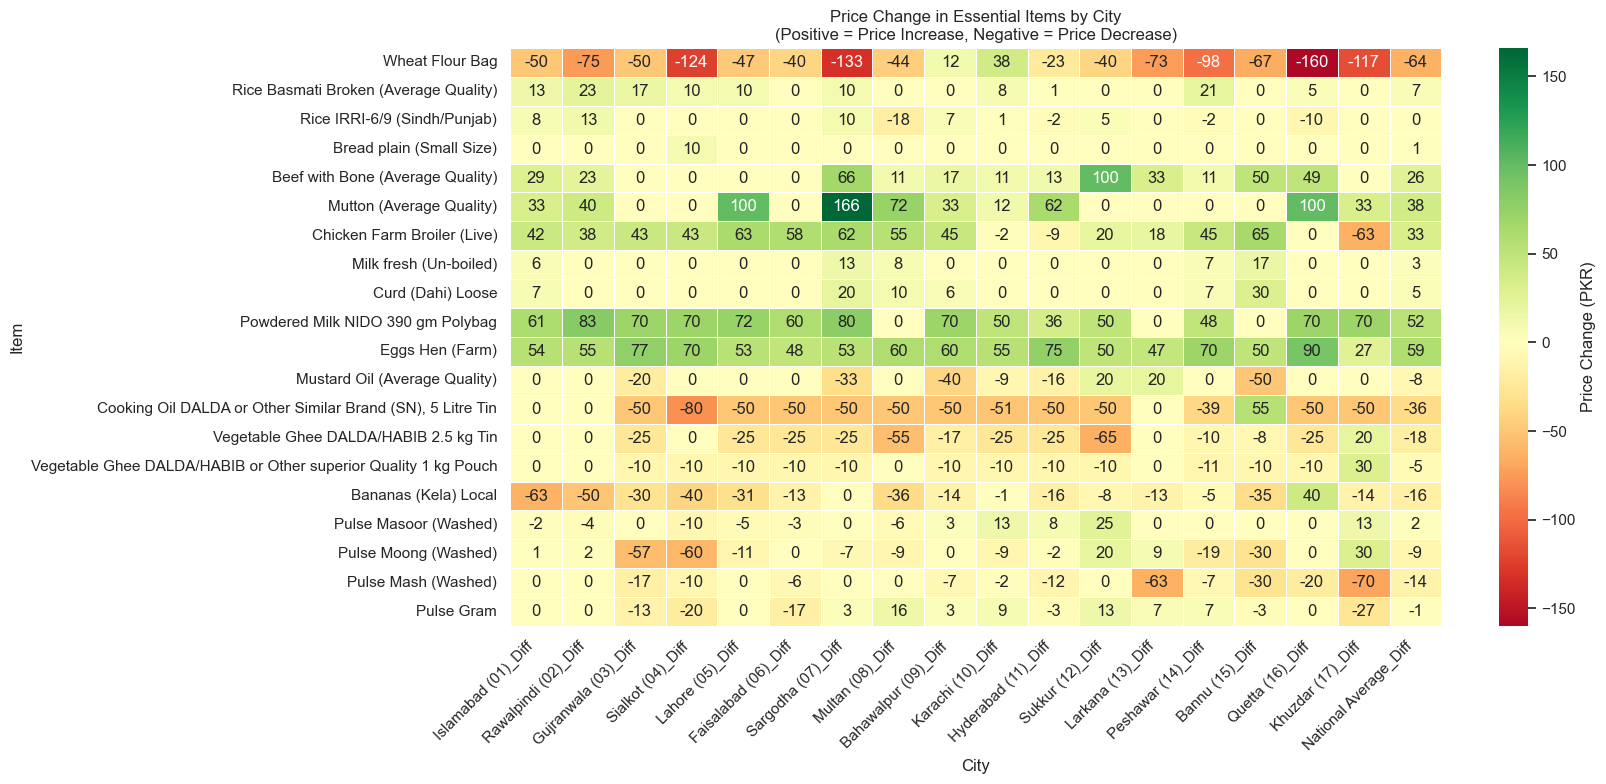

In [8]:
# Plot difference heatmap
plt.figure(figsize=(17, 8))
sns.heatmap(df_diff, annot=True, fmt=".0f", cmap="RdYlGn", center=0, linewidths=0.5,
            cbar_kws={'label': 'Price Change (PKR)'})
plt.title("Price Change in Essential Items by City\n(Positive = Price Increase, Negative = Price Decrease)")
plt.ylabel("Item")
plt.xlabel("City")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

## 8. Find maximum increase and maximum decrease for each item

In [9]:
# DataFrame to store max increase/decrease
highlight_df = pd.DataFrame(index=df_diff.index)

# Find maximum increase and maximum decrease for each item
highlight_df['Max_Increase'] = df_diff.max(axis=1)
highlight_df['Max_Decrease'] = df_diff.min(axis=1)

# Identify which city had max increase and decrease
highlight_df['City_Max_Increase'] = df_diff.idxmax(axis=1).str.replace('_Diff','')
highlight_df['City_Max_Decrease'] = df_diff.idxmin(axis=1).str.replace('_Diff','')

highlight_df


,Max_Increase,Max_Decrease,City_Max_Increase,City_Max_Decrease
Sl._Description,,,,
Wheat Flour Bag,38.48,-160.00,Karachi (10),Quetta (16)
Rice Basmati Broken (Average Quality),23.34,0.00,Rawalpindi (02),Faisalabad (06)
Rice IRRI-6/9 (Sindh/Punjab),12.62,-17.94,Rawalpindi (02),Multan (08)
Bread plain (Small Size),10.00,0.00,Sialkot (04),Islamabad (01)
Beef with Bone (Average Quality),100.00,0.00,Sukkur (12),Gujranwala (03)
Mutton (Average Quality),166.12,0.00,Sargodha (07),Gujranwala (03)
Chicken Farm Broiler (Live),65.00,-63.31,Bannu (15),Khuzdar (17)
Milk fresh (Un-boiled),16.60,0.00,Bannu (15),Rawalpindi (02)
Curd (Dahi) Loose,30.00,0.00,Bannu (15),Rawalpindi (02)


## 9. Visualize Highlights (Bar Plot)

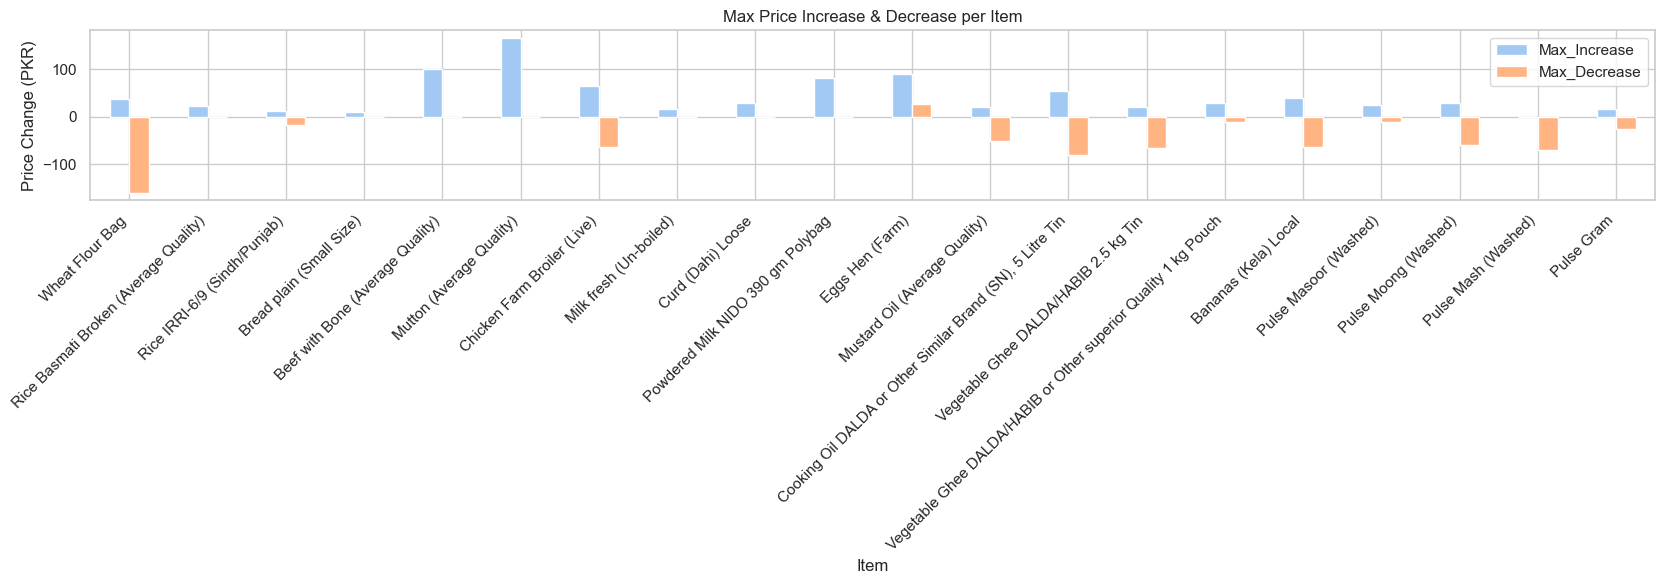

In [10]:
highlight_df[['Max_Increase','Max_Decrease']].plot(kind='bar', figsize=(17,6))
plt.title("Max Price Increase & Decrease per Item")
plt.ylabel("Price Change (PKR)")
plt.xlabel("Item")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


## 10. Analysis of Price Changes

This analysis helps visualize **weekly price trends of essential items** in Pakistan:

- Heatmaps provide a clear **city-wise comparison**.  
- Price difference analysis shows **which items increased or decreased**.  
- Highlights help quickly identify **cities with the highest fluctuations**.  

This notebook is a **practical project for aspiring data analysts**, demonstrating skills in:
- Data cleaning and transformation  
- Multi-sheet Excel handling  
- Visualization with Matplotlib and Seaborn  
- Comparative analysis for weekly trends

This comparison helps:
- Consumers understand which cities are more expensive for essential items.
- Policymakers monitor price volatility and inflation trends.
- Businesses track pricing strategy impacts across regions.
